# Survival Analysis - LightGBM + SHAP

In [1]:
!pip install -U sentence-transformers > /dev/null 2>&1
!pip install xgboost > /dev/null 2>&1
!pip install scikit-learn==1.4.2 scikit-survival==0.23.1 > /dev/null 2>&1
!pip install torchtuples > /dev/null 2>&1
!pip install pycox > /dev/null 2>&1
!pip install numpy==1.21.5  > /dev/null 2>&1
!pip install interpret-core  > /dev/null 2>&1
!pip install lightgbm > /dev/null 2>&1
!pip install shap > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import kagglehub
import contextlib
import logging

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
import shap



In [3]:
# Life Expectancy dataset
life_exp_path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
life_exp_file = os.path.join(life_exp_path, "Life Expectancy Data.csv")
life_exp_df = pd.read_csv(life_exp_file)
print("Life Expectancy Sample:")
print(life_exp_df.head())

# Heart Failure dataset (not used in LightGBM, but kept for context)
heart_path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
heart_file = os.path.join(heart_path, "heart.csv")
heart_df = pd.read_csv(heart_file)
print("Heart Failure Sample:")
print(heart_df.head())

# Age Dataset
age_path = kagglehub.dataset_download("imoore/age-dataset")
age_file = os.path.join(age_path, "AgeDataset-V1.csv")
age_df = pd.read_csv(age_file)
print("Age Dataset Sample:")
print(age_df.head())

# World important events Dataset
events_path = kagglehub.dataset_download("saketk511/world-important-events-ancient-to-modern")
events_file = os.path.join(events_path, "World Important Dates.csv")
events_df = pd.read_csv(events_file)
print("World Important Events Sample:")
print(events_df.head())

# Plane Crash Dataset
plane_crash_path = kagglehub.dataset_download("nguyenhoc/plane-crash")
plane_crash_file = os.path.join(plane_crash_path, "planecrashinfo_20181121001952.csv")  
planes_df = pd.read_csv(plane_crash_file)
print("Historical Plane Crashes Sample:")
print(planes_df.head())

# Gloabl Life Expectancy dataset
global_le_path = kagglehub.dataset_download("hasibalmuzdadid/global-life-expectancy-historical-dataset")
global_le_file = os.path.join(global_le_path, "global life expectancy dataset.csv")
global_le_df = pd.read_csv(global_le_file)
print("Global Life Expectancy Historical Dataset Sample:")
print(global_le_df.head())

# US death rate Dataset
death_rates_path = kagglehub.dataset_download("melissamonfared/death-rates-united-states")
death_rates_file = os.path.join(death_rates_path, "Death_rates.csv")
death_rates_df = pd.read_csv(death_rates_file)
print("Death Rates United States Dataset Sample:")
print(death_rates_df.head())

Life Expectancy Sample:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GD

In [45]:
print(events_df.columns)
print(planes_df.columns)
print(global_le_df.columns)
print(death_rates_df.columns)

Index(['Sl. No', 'Name of Incident', 'Date', 'Month', 'Year', 'Country',
       'Type of Event', 'Place Name', 'Impact', 'Affected Population',
       'Important Person/Group Responsible', 'Outcome'],
      dtype='object')
Index(['date', 'time', 'location', 'operator', 'flight_no', 'route', 'ac_type',
       'registration', 'cn_ln', 'aboard', 'fatalities', 'ground', 'summary'],
      dtype='object')
Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020'],
      dtype='object'

In [4]:
# -------------------------- Data Cleaning --------------------------
# Life Expectancy: drop rows with missing target and fill missing values
life_exp_df = life_exp_df.dropna(subset=['Life expectancy '])
life_exp_df['Alcohol'] = life_exp_df.groupby(['Country', 'Year'])['Alcohol'].transform(
    lambda x: x.fillna(x.median()))
life_exp_df['Alcohol'] = life_exp_df['Alcohol'].fillna(life_exp_df['Alcohol'].median())
life_exp_df['GDP'] = life_exp_df.groupby('Country')['GDP'].transform(
    lambda x: x.fillna(x.median()))
life_exp_df['GDP'] = life_exp_df['GDP'].fillna(life_exp_df['GDP'].median())
life_exp_df = life_exp_df.drop(columns=[
    'Hepatitis B', 'Population', 'Income composition of resources',
    ' thinness  1-19 years', ' thinness 5-9 years'
])
life_exp_df = life_exp_df.fillna(method='ffill').fillna(method='bfill')

# Heart Failure: simple one-hot encoding for some categorical features
heart_df = pd.get_dummies(heart_df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)
heart_df['ExerciseAngina'] = heart_df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# Age Dataset: drop rows with missing 'Death year' or 'Age of death'
age_df = age_df.dropna(subset=['Death year', 'Age of death'])
for col in ['Gender', 'Country', 'Occupation', 'Short description']:
    age_df[col] = age_df[col].fillna('Unknown')
age_df['Country'] = age_df['Country'].str.split(';').str[0]
occupation_counts = age_df['Occupation'].value_counts()
age_df['Occupation'] = np.where(
    age_df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
    age_df['Occupation'],
    'Other'
)
age_df['Gender'] = np.where(age_df['Gender'] == 'Male', 1,
                            np.where(age_df['Gender'] == 'Female', 0, 0.5))
age_df = age_df.drop(columns=['Manner of death'])


# Clean World Important Events dataset (events_df)
# Assume the dataset has a column named "Date, Month, Year" that we convert to datetime.
events_df['Event_Date'] = pd.to_datetime(
    events_df[['Date', 'Month', 'Year']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)
# Standardize country names: strip whitespace and title-case them.
events_df['Country'] = events_df['Country'].str.strip().str.title()
# Optionally, select only the relevant columns.
columns_to_keep = ['Name of Incident', 'Event_Date', 'Country', 'Type of Event', 'Impact', 'Affected Population']
events_df = events_df[columns_to_keep]

# Clean Historical Plane Crashes dataset (planes_df)
# Convert the 'date' column to datetime. Adjust the column name if needed.
planes_df['Crash_Date'] = pd.to_datetime(planes_df['date'], errors='coerce')
# If a 'location' column exists, extract the country (assumes country is the last part of the location string).
if 'location' in planes_df.columns:
    planes_df['Country'] = planes_df['location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else x)
    planes_df['Country'] = planes_df['Country'].str.title()
# Select only a subset of columns that you deem useful.
plane_columns = ['date', 'Crash_Date', 'Country', 'operator', 'ac_type', 'aboard', 'fatalities', 'summary']
planes_df = planes_df[plane_columns]

# -------------------------- Cleaning Global Life Expectancy Dataset (global_le_df) --------------------------
# Reshape from wide to long format
global_le_df = global_le_df.melt(
    id_vars=['Country Name', 'Country Code'],
    var_name='Year',
    value_name='Life_Expectancy'
)

# Clean and convert
global_le_df = global_le_df.rename(columns={'Country Name': 'Country'})
global_le_df['Country'] = global_le_df['Country'].str.strip().str.title()
global_le_df['Year'] = pd.to_numeric(global_le_df['Year'], errors='coerce')
global_le_df['Life_Expectancy'] = pd.to_numeric(global_le_df['Life_Expectancy'], errors='coerce')

# Aggregate by country (average across years)
global_le_agg = (
    global_le_df.groupby("Country")["Life_Expectancy"]
    .mean()
    .reset_index()
    .rename(columns={"Life_Expectancy": "global_life_exp"})
)


# -------------------------- Cleaning Death Rates Dataset (death_rates_df) --------------------------
# Fix column identification
death_rates_df.columns = death_rates_df.columns.str.strip()

# Identify correct columns (based on your column print)
death_rates_df = death_rates_df.rename(columns={
    'ESTIMATE': 'Death_Rate',
    'STUB_LABEL': 'Age_Group'
})
# Clean death rates
death_rates_df['Death_Rate'] = (
    death_rates_df['Death_Rate']
    .astype(str)
    .str.replace(',', '')
    .astype(float)
)
# If the dataset does not include a 'Country' column, add one (assuming it applies to the United States)
if 'Country' not in death_rates_df.columns:
    death_rates_df['Country'] = "United States"
else:
    # Standardize the country names.
    death_rates_df['Country'] = death_rates_df['Country'].str.strip().str.title()

# Aggregate average death rate per country.
death_rates_agg = (
    death_rates_df.groupby('Country')['Death_Rate']
    .mean()
    .reset_index()
    .rename(columns={'Death_Rate': 'avg_death_rate'})
)

# Print final missing values summary
print("\nFinal Missing Values:")
print("Life Expectancy:\n", life_exp_df.isnull().sum())
print("Heart Failure:\n", heart_df.isnull().sum())
print("Age Dataset:\n", age_df.isnull().sum())

print("\nNew Dataset Summary:")
print("World Important Events Missing Values:\n", events_df.isnull().sum())
print("Historical Plane Crashes Missing Values:\n", planes_df.isnull().sum())
print("Gloabl Life Expectancy Missing Values:\n", global_le_df.isnull().sum())
print("Death Rates Dataset Missing Values:\n", death_rates_df.isnull().sum())


/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctio


Final Missing Values:
Life Expectancy:
 Country                   0
Year                      0
Status                    0
Life expectancy           0
Adult Mortality           0
infant deaths             0
Alcohol                   0
percentage expenditure    0
Measles                   0
 BMI                      0
under-five deaths         0
Polio                     0
Total expenditure         0
Diphtheria                0
 HIV/AIDS                 0
GDP                       0
Schooling                 0
dtype: int64
Heart Failure:
 Age                  0
Sex                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
ExerciseAngina       0
Oldpeak              0
HeartDisease         0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_Normal    0
RestingECG_ST        0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64
Age Dataset:
 Id                   0
Name                 0
Short descrip

In [49]:
def enhanced_feature_engineering(df, life_exp_df, events_df, planes_df, global_le_df, death_rates_df, top_tfidf=20):
    """
    Performs cleaning and enhanced synthetic feature engineering.
    - Normalizes key synthetic features.
    - Merges country-level data from life expectancy, global life expectancy,
      events, plane crashes, and death rates.
    - Computes TF-IDF features from 'Occupation' + 'Short description' and retains only the top `top_tfidf` features.
    - Creates several interaction terms.
    """
    # -------- Basic Cleaning (existing) --------
    for col in ['Gender', 'Country', 'Occupation', 'Short description']:
        df[col] = df[col].fillna('Unknown')
    df['Country'] = df['Country'].str.split(';').str[0]
    occupation_counts = df['Occupation'].value_counts()
    df['Occupation'] = np.where(df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
                                df['Occupation'], 'Other')
    df['Gender'] = np.where(df['Gender'] == 'Male', 1,
                            np.where(df['Gender'] == 'Female', 0, 0.5))
    
    # -------- Existing Synthetic Features --------
    # 1. Stress Score (normalized)
    stress_map = {
        'Politician': 9, 'Military personnel': 8, 'Journalist': 7,
        'Businessperson': 6, 'Artist': 5, 'Teacher': 4, 
        'Researcher': 3, 'Other': 5, 'Unknown': 5
    }
    df['stress_score_raw'] = df['Occupation'].map(stress_map).fillna(5).astype('float32')
    df['stress_score'] = df['stress_score_raw'] / 9.0

    # 2. BMI from Country (using median from life_exp_df and standardizing)
    # Ensure that the BMI column in life_exp_df is numeric.
    life_exp_df[' BMI '] = pd.to_numeric(life_exp_df[' BMI '], errors='coerce')
    country_bmi = life_exp_df.groupby('Country')[' BMI '].median().to_dict()
    df['avg_bmi_raw'] = df['Country'].map(country_bmi).fillna(25).astype('float32')
    df['avg_bmi'] = (df['avg_bmi_raw'] - df['avg_bmi_raw'].mean()) / df['avg_bmi_raw'].std()

    # 3. Heart Disease Risk (Composite Score)
    df['heart_disease_risk'] = (0.4 * df['Gender'] +
                                0.3 * df['stress_score'] +
                                0.3 * df['avg_bmi']).astype('float32')

    # 4. Smoking Prevalence (logistic transformation)
    birth_years = df['Birth year'].to_numpy()
    df['smoking_prev'] = (1 / (1 + np.exp((birth_years - 1950) / 10))).astype('float32')
    df['smoking_prev'] = np.clip(df['smoking_prev'], 0.1, 0.6)

    # -------- 5. Country-Level Features: merge and scale --------
    life_exp_filtered = (
        life_exp_df[['Country', 'Alcohol', 'GDP', 'Schooling']]
        .sort_values('Country')
        .groupby('Country')
        .median()  # aggregate numeric columns
        .add_prefix('country_')
    )
    # Ensure numeric conversion in the aggregated life_exp data
    for col in ['country_Alcohol', 'country_GDP', 'country_Schooling']:
        life_exp_filtered[col] = pd.to_numeric(life_exp_filtered[col], errors='coerce')
    
    df['Country'] = df['Country'].astype('category')
    df = df.join(life_exp_filtered, on='Country', how='left')
    for col in ['country_Alcohol', 'country_GDP', 'country_Schooling']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())
        df[col + '_scaled'] = (df[col] - df[col].mean()) / df[col].std()

    # -------- 6. New Dataset Aggregations and Merges --------
    # 6a. World Important Events: count number of events per country
    events_agg = events_df.groupby('Country').size().reset_index(name='num_events')
    df = df.merge(events_agg, on='Country', how='left')
    df['num_events'] = df['num_events'].fillna(0).astype('int32')
    
    # 6b. Historical Plane Crashes: aggregate count and average fatalities per country
    # Ensure fatalities is numeric
    planes_df['fatalities'] = pd.to_numeric(planes_df['fatalities'], errors='coerce')
    planes_agg = planes_df.groupby('Country').agg({
        'Crash_Date': 'count',   # count of crashes
        'fatalities': 'mean'      # average fatalities per crash
    }).reset_index().rename(columns={'Crash_Date': 'plane_crash_count', 'fatalities': 'avg_plane_fatalities'})
    df = df.merge(planes_agg, on='Country', how='left')
    df['plane_crash_count'] = df['plane_crash_count'].fillna(0).astype('int32')
    df['avg_plane_fatalities'] = pd.to_numeric(df['avg_plane_fatalities'], errors='coerce')
    df['avg_plane_fatalities'] = df['avg_plane_fatalities'].fillna(df['avg_plane_fatalities'].median())
    
    # 6c. Global Life Expectancy: aggregate average life expectancy per country from global_le_df
    global_le_df.columns = global_le_df.columns.str.strip()
    global_le_df.rename(columns={'Country Name': 'Country', 'Year[1960 - Present]': 'Life_Expectancy'}, inplace=True)
    global_le_df['Country'] = global_le_df['Country'].str.strip().str.title()
    global_le_df['Life_Expectancy'] = pd.to_numeric(global_le_df['Life_Expectancy'], errors='coerce')
    global_le_agg = (
        global_le_df.groupby('Country')['Life_Expectancy']
        .mean()
        .reset_index()
        .rename(columns={'Life_Expectancy': 'global_life_exp'})
    )
    df = df.merge(global_le_agg, on='Country', how='left')
    df['global_life_exp'] = df['global_life_exp'].fillna(df['global_life_exp'].median())
    
    # 6d. Death Rates: aggregate average death rate per country.
    if 'Country' not in death_rates_df.columns:
        death_rates_df['Country'] = "United States"
    # Remove any commas in the death rate values and convert to numeric.
    death_rates_df['Death_Rate'] = death_rates_df['Death_Rate'].replace({',': ''}, regex=True)
    death_rates_df['Death_Rate'] = pd.to_numeric(death_rates_df['Death_Rate'], errors='coerce')
    death_rates_agg = death_rates_df.groupby('Country')['Death_Rate'].mean().reset_index().rename(columns={'Death_Rate': 'avg_death_rate'})
    df = df.merge(death_rates_agg, on='Country', how='left')
    df['avg_death_rate'] = pd.to_numeric(df['avg_death_rate'], errors='coerce')
    df['avg_death_rate'] = df['avg_death_rate'].fillna(df['avg_death_rate'].median())
    
    # -------- 7. TF-IDF on (Occupation + Short description) --------
    text_data = (
        df['Occupation'].fillna('Unknown') + " " + 
        df['Short description'].fillna('')
    )
    tfidf = TfidfVectorizer(
        max_features=100,
        ngram_range=(1,2),
        stop_words='english',
        min_df=5  # Add minimum document frequency
    )
    text_features = tfidf.fit_transform(text_data)
    text_df = pd.DataFrame(
        text_features.toarray(),
        columns=[f"tfidf_{i}" for i in range(text_features.shape[1])],
        index=df.index
    )
    # Select top TF-IDF features by absolute Pearson correlation with 'Age of death'
    target = df['Age of death']
    correlations = text_df.apply(lambda col: col.corr(target))
    top_tfidf_features = correlations.abs().sort_values(ascending=False).head(top_tfidf).index
    text_df = text_df[top_tfidf_features]
    df = pd.concat([df, text_df], axis=1)
    
    # -------- 8. Additional Interaction Terms --------
    df['stress_x_smoking'] = (df['stress_score'] * df['smoking_prev']).astype('float32')
    df['stress_x_avg_bmi'] = (df['stress_score'] * df['avg_bmi']).astype('float32')
    df['avg_bmi_x_smoking'] = (df['avg_bmi'] * df['smoking_prev']).astype('float32')
    df['heart_x_stress'] = (df['heart_disease_risk'] * df['stress_score']).astype('float32')
    df['heart_x_avg_bmi'] = (df['heart_disease_risk'] * df['avg_bmi']).astype('float32')
    
    # New interaction terms with new aggregated features:
    df['stress_x_events'] = (df['stress_score'] * df['num_events']).astype('float32')
    df['global_life_exp_x_planes'] = (df['global_life_exp'] * df['plane_crash_count']).astype('float32')
    
    return df


In [63]:
# -------------------------- Global Batch Settings --------------------------
BATCH_SIZE = 1000000
N_ITERATIONS = 90
BASE_RANDOM_STATE = 42

# Updated get_processed_batch: pass the new datasets to the feature engineering function.
def get_processed_batch(random_seed):
    batch_df = age_df.sample(n=BATCH_SIZE, random_state=random_seed).copy()
    processed_batch = enhanced_feature_engineering(
        batch_df, 
        life_exp_df, 
        events_df, 
        planes_df, 
        global_le_df, 
        death_rates_df,
        top_tfidf=20
    )
    return processed_batch


In [51]:
def final_lgbm_model(df):
    """
    Trains a final LightGBM regressor using the tuned hyperparameters on the processed DataFrame,
    evaluates it on a hold-out validation set, and computes SHAP feature importances.
    Returns the trained model, RMSE, MAE, full SHAP importances, and the top 10 features.
    """
    # Set environment variable and logger level to help suppress LightGBM messages.
    os.environ["LIGHTGBM_VERBOSE"] = "-1"
    logging.getLogger("lightgbm").setLevel(logging.ERROR)

    # Update feature_list to include new features (if available)
    feature_list = [
        'stress_score', 'avg_bmi', 'heart_disease_risk', 
        'smoking_prev', 'country_Alcohol', 'country_GDP', 
        'stress_x_smoking', 'stress_x_avg_bmi', 'avg_bmi_x_smoking', 
        'heart_x_stress', 'heart_x_avg_bmi',
        'num_events', 'plane_crash_count', 'avg_plane_fatalities', 
        'global_life_exp', 'avg_death_rate'
    ]
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features]
    y = df['Age of death']
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    # Tuned hyperparameters (these you can update as desired)
    best_params = {
        'learning_rate': 0.05,
        'max_depth': 4,
        'min_child_samples': 20,
        'n_estimators': 200,
        'num_leaves': 31
    }
    
    # Pass verbose=-1 in the constructor to suppress output.
    final_model = lgb.LGBMRegressor(random_state=BASE_RANDOM_STATE, verbose=-1, **best_params)
    
    # Suppress output during training by redirecting stdout and stderr.
    with open(os.devnull, 'w') as devnull, \
         contextlib.redirect_stdout(devnull), \
         contextlib.redirect_stderr(devnull):
        final_model.fit(X_train, y_train)
    
    y_pred = final_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    
    # Compute SHAP values and importance
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_val)
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'shap_importance': shap_importance
    }).sort_values('shap_importance', ascending=False)
    
    top_features = shap_importance_df.head(10)
    
    return final_model, rmse, mae, shap_importance_df, top_features


In [75]:
processed_batch = get_processed_batch(BASE_RANDOM_STATE)
final_model, final_rmse, final_mae, final_shap_importance, top_features = final_lgbm_model(processed_batch)

print("Final LightGBM Model Performance:")
print("Validation RMSE:", final_rmse)
print("Validation MAE:", final_mae)
print("\nTop 10 Features by SHAP Importance:")
print(top_features)
print("\nFull SHAP Feature Importance:")
print(final_shap_importance)


/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Final LightGBM Model Performance:
Validation RMSE: 15.529070985581578
Validation MAE: 12.182521455597433

Top 10 Features by SHAP Importance:
              feature  shap_importance
3        smoking_prev         1.637505
12  plane_crash_count         1.119170
10    heart_x_avg_bmi         0.977731
16           tfidf_97         0.503957
4     country_Alcohol         0.494714
22            tfidf_2         0.284901
0        stress_score         0.233615
18           tfidf_67         0.211000
19           tfidf_61         0.207431
8   avg_bmi_x_smoking         0.165124

Full SHAP Feature Importance:
                 feature  shap_importance
3           smoking_prev         1.637505
12     plane_crash_count         1.119170
10       heart_x_avg_bmi         0.977731
16              tfidf_97         0.503957
4        country_Alcohol         0.494714
22               tfidf_2         0.284901
0           stress_score         0.233615
18              tfidf_67         0.211000
19              tfid

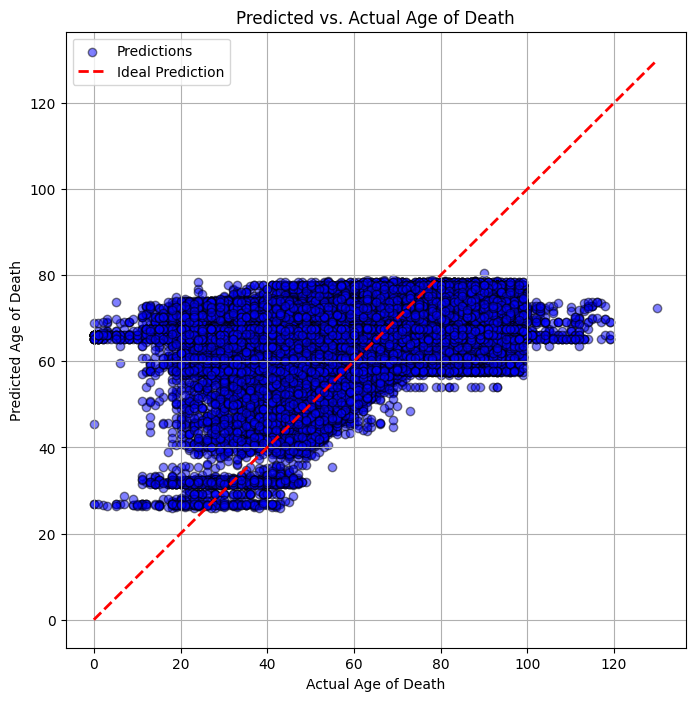

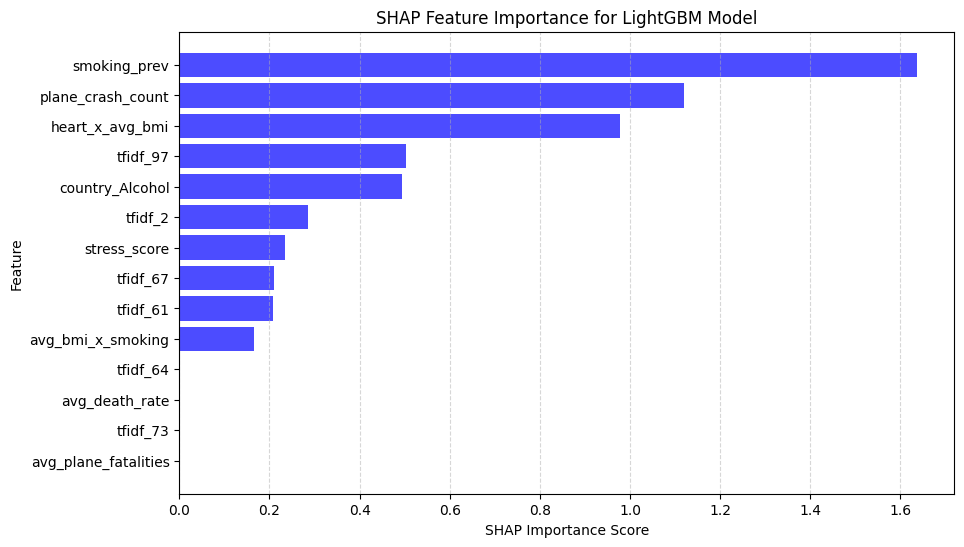

In [77]:
import matplotlib.pyplot as plt

# Extract the feature set from the processed batch (same as used in final_lgbm_model)
feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 
                'smoking_prev', 'country_Alcohol', 'country_GDP', 
                'stress_x_smoking', 'stress_x_avg_bmi', 'avg_bmi_x_smoking', 
                'heart_x_stress', 'heart_x_avg_bmi']
tfidf_cols = [col for col in processed_batch.columns if col.startswith('tfidf_')]
features = feature_list + tfidf_cols

# Split the processed batch into training and validation sets
X = processed_batch[features]
y = processed_batch['Age of death']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)

# Ensure X_val has all the features the model was trained on
expected_features = final_model.feature_name_

# Add missing features with zeros
missing_features = set(expected_features) - set(X_val.columns)
for feature in missing_features:
    X_val[feature] = 0  # Fill missing features with zero

# Remove extra features not in the trained model
X_val = X_val[expected_features]  # Ensure correct feature order

# Now predict
y_pred = final_model.predict(X_val)


# Plot predicted vs. actual ages
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5, color='blue', edgecolor='k', label="Predictions")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label="Ideal Prediction")
plt.xlabel("Actual Age of Death")
plt.ylabel("Predicted Age of Death")
plt.title("Predicted vs. Actual Age of Death")
plt.legend()
plt.grid(True)
plt.show()

# SHAP Feature Importance Plot
shap_importance = {
    "feature": [
        "smoking_prev", "plane_crash_count", "heart_x_avg_bmi", "tfidf_97",
        "country_Alcohol", "tfidf_2", "stress_score", "tfidf_67",
        "tfidf_61", "avg_bmi_x_smoking", "tfidf_64", "avg_death_rate",
        "avg_plane_fatalities", "tfidf_73"
    ],
    "shap_importance": [
        1.637505, 1.119170, 0.977731, 0.503957, 0.494714, 0.284901,
        0.233615, 0.211000, 0.207431, 0.165124, 0.000632, 0.000000,
        0.000000, 0.000000
    ]
}

# Convert to DataFrame and sort values
shap_df = pd.DataFrame(shap_importance).sort_values(by="shap_importance", ascending=True)

# Plot SHAP feature importance
plt.figure(figsize=(10, 6))
plt.barh(shap_df["feature"], shap_df["shap_importance"], color='blue', alpha=0.7)
plt.xlabel("SHAP Importance Score")
plt.ylabel("Feature")
plt.title("SHAP Feature Importance for LightGBM Model")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()
